In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random

np.random.seed(1337)  # for reproducibility

def setGPU():
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    #config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))
setGPU()

print('libs loaded')

Using TensorFlow backend.


libs loaded


In [2]:
# parameters
data_path = '../data/seg_data/{}/'
size = 128

def load_filenames(path):
    filenames = []
    for (dirpath, dirnames, filenames) in walk(data_path.format('x')):
        filenames.extend(filenames)
        break
    for f in filenames:
        if not '.npy' in f:
            del f
    training_filenames = []
    validation_filenames = []
    for f in filenames:
        if 'case1_' in f:
            validation_filenames.append(f)
        else:
            training_filenames.append(f)
            
            
    return training_filenames, validation_filenames
    
training_filenames, validation_filenames = load_filenames(data_path)

print(training_filenames)
print(validation_filenames)

['case10_label11.npy', 'case6_label11.npy', 'case8_label11.npy', 'case10_label6.npy', 'case9_label19.npy', 'case2_label13.npy', 'case9_label7.npy', 'case5_label3.npy', 'case6_label15.npy', 'case6_label8.npy', 'case10_label4.npy', 'case9_label13.npy', 'case3_label6.npy', 'case2_label5.npy', 'case9_label12.npy', 'case6_label9.npy', 'case9_label17.npy', 'case9_label10.npy', 'case8_label12.npy', 'case8_label4.npy', 'case4_label14.npy', 'case9_label5.npy', 'case4_label6.npy', 'case8_label5.npy', 'case5_label8.npy', 'case4_label3.npy', 'case8_label9.npy', 'case8_label18.npy', 'case8_label15.npy', 'case6_label19.npy', 'case8_label10.npy', 'case9_label8.npy', 'case4_label11.npy', 'case5_label17.npy', 'case4_label12.npy', 'case3_label16.npy', 'case2_label8.npy', 'case2_label7.npy', 'case8_label19.npy', 'case3_label7.npy', 'case8_label8.npy', 'case4_label19.npy', 'case3_label15.npy', 'case6_label6.npy', 'case5_label18.npy', 'case4_label15.npy', 'case5_label5.npy', 'case4_label4.npy', 'case5_labe

In [3]:

def model():
    from keras.models import Model
    from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation, Dense, Flatten
    
    def conv(input_tensor, depth):
        conv_tensor = Conv3D(depth, 3, padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
        bn = BatchNormalization()(conv_tensor) # use_bias=False
        output_tensor = Activation('relu')(bn)
        return output_tensor
    
    def pool(input_tensor):
        output_tensor = MaxPooling3D(pool_size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def up(input_tensor):
        output_tensor = UpSampling3D(size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def skip(input_tensor1, input_tensor2):
        output_tensor = Concatenate(axis=-1)([input_tensor1, input_tensor2])
        return output_tensor
    
    depth = 4
    
    input_img = Input(shape=(size, size, size, 1))
    
    conv1 = conv(input_img, depth)
    conv2 = conv(conv1, depth * 2)
    
    pool1 = pool(conv2)
    
    conv3 = conv(pool1, depth * 2)
    conv4 = conv(conv3, depth * 4)
    
    pool2 = pool(conv4)
    
    conv5 = conv(pool2, depth * 4)
    conv6 = conv(conv5, depth * 8)
    
    pool3 = pool(conv6)
    
    conv7 = conv(pool3, depth * 8)
    conv8 = conv(conv7, depth * 16)   

    up1 = up(conv8)
    
    skip1 = skip(conv6, up1)
    
    conv9 = conv(skip1, depth * 8)
    conv10 = conv(conv9, depth * 8)
    
    up2   = up(conv10)
    
    skip2 = skip(conv4, up2)
    
    conv11 = conv(skip2, depth * 4)
    conv12 = conv(conv11, depth * 4)
    
    up3   = up(conv12)
    
    skip3 = skip(conv2, up3)
    
    conv13 = conv(skip3, depth * 2)
    conv14 = conv(conv13, depth * 2)    
   
    conv15 = conv(conv14, 1)

    output_img = conv15
    
    # model
    model = Model(inputs=input_img, outputs=output_img)
    print (model.output_shape)

    # optimizer
    opt = keras.optimizers.Adam(lr=1e-2)#32-5,16-3
    
    model.compile(optimizer=opt,
                  loss = 'mse',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

model = model()

(None, 128, 128, 128, 1)
Instructions for updating:
keep_dims is deprecated, use keepdims instead
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 128, 128, 128 112         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 128 16          conv3d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 128, 128, 128 0           batch_normalization_1[0][0]      
___________

In [4]:
import re

def generator(batch_size, filenames):
    while 1:
        shape = (batch_size, size, size, size, 1)
        shape2 = (batch_size, 20)
        
        x_out = np.zeros(shape)
        y_out = np.zeros(shape)
        y_out2 = np.zeros(shape2)
        
        for i in range(batch_size):
            filename = random.choice(filenames)
            #filename = filenames[0]
            x = np.load(data_path.format('x') + filename)
            y = np.load(data_path.format('y') + filename)
            x = np.reshape(x, (size, size, size, -1))
            y = np.reshape(y, (size, size, size, -1))
            
            x_out[i] = x
            y_out[i] = y
            
            label = int(re.sub("\D", "", filename.split('_')[0]))
            label_one_hot = [0] * 20
            label_one_hot[label] = 1
            
            y_out2[i] = label_one_hot
            
        #yield (x_out, y_out)
        yield (x_out, y_out)

In [ ]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss',
#                                min_delta=0,
#                                patience=2,
#                                verbose=0,
#                                mode='auto')
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./save/model.weights.best.h5', verbose=1, monitor='val_loss',save_best_only=False, mode='min') 

history = model.fit_generator(  generator(4, training_filenames),
                                validation_data=generator(8, validation_filenames),
                                steps_per_epoch=10,
                                validation_steps = 10,
                                epochs=2000,
                                callbacks=[checkpoint])

Epoch 1/2000
 4/10 [===========>..................] - ETA: 5s - loss: 0.0089 - acc: 0.9874

In [ ]:
def plot_result():
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_result()

In [23]:

#model.save_weights('./save/model_weights.h5')

In [25]:
del model

case1_label19.npy


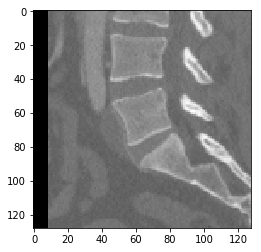

In [10]:
filename = validation_filenames[3]
print(filename)
x = np.load(data_path.format('x') + filename)
plt.imshow(x[:,:,65], cmap='gray')
x = np.reshape(x, (1, 128, 128, 128, -1))

(1, 128, 128, 128, 1)
0.4427474


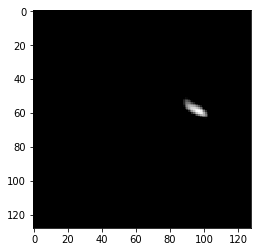

In [11]:
y = model.predict(x)
print(y.shape)
y = np.reshape(y, (128, 128, 128))
print(np.max(y))
plt.imshow(y[:,:,65], cmap='gray')

In [ ]:
y = np.load(data_path.format('y') + validation_filenames[0])
plt.imshow(y[:,:,65], cmap='gray')

In [18]:
model.load_weights('./save/model.weights.best.h5')

In [26]:
import random
import re

def generator(batch_size, filenames):
    size = 128
    
    shape = (batch_size, size, size, size, 1)

    x_out = np.zeros(shape)
    y_out = np.zeros(shape)

    for i in range(batch_size):
        filename = random.choice(filenames)
        #filename = filenames[0]
        x = np.load(data_path.format('x') + filename)
        y = np.load(data_path.format('y') + filename)
        x = np.reshape(x, (size, size, size, -1))
        y = np.reshape(y, (size, size, size, -1))

        x_out[i] = x
        y_out[i] = y
    
        print(filename.split('_')[0])
        print(int(re.sub("\D", "", filename.split('_')[0])))
        
        label = int(re.sub("\D", "", filename.split('_')[0]))
        y_out2 = [0] * 20
        y_out2[label] = 1
        print(y_out2)
        
generator(1, training_filenames)

case9
9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [31]:
print(random.randint(-2,2))

1


In [25]:
    x_bias, y_bias, z_bias = random.randint(-2,2), random.randint(-2,2), random.randint(-2,2)
    x_range = (x_bias, 127) if x_bias > 0 else (0, size + x_bias -1)
    y_range = (y_bias, 127) if y_bias > 0 else (0, size + y_bias -1)
    z_range = (z_bias, 127) if z_bias > 0 else (0, size + z_bias -1)
    print(x_range)

(0, 125)
